In [1]:
# This code mounts your Google Drive to the Google Colab environment.
# It allows you to access files stored in your Google Drive directly from Colab.
# After running this code, you will be prompted to authorize Colab to access your Google Drive.
# Once authorized, you can read from and write to your Google Drive as if it were a local directory.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Import Library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import math

In [3]:
# Define Directories
train_dir = "/content/drive/MyDrive/Bangkit 2024/Dataset_CatarActNow/Split_Augmentation/train"
valid_dir = "/content/drive/MyDrive/Bangkit 2024/Dataset_CatarActNow/Split_Augmentation/valid"
test_dir = "/content/drive/MyDrive/Bangkit 2024/Dataset_CatarActNow/Split_Augmentation/test"

In [11]:
# Image Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

train_batches = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_batches = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_batches = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 3928 images belonging to 3 classes.
Found 1245 images belonging to 3 classes.
Found 1248 images belonging to 3 classes.


In [12]:
# Retrieve One Batch of Images and Labels
imgs, labels = next(train_batches)

In [13]:
# Load Pretrained Model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.summary()
print(type(base_model))

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_203 (Conv2D)         (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_203 (B  (None, 149, 149, 32)         96        ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_203 (Activation  (None, 149, 149, 32)         0         ['batch_norm

In [18]:
# Build the Model
model = models.Model(inputs=base_model.input, outputs=base_model.output)
model.trainable = False

# Add GlobalAveragePooling2D and Dense layer for classification
x = layers.GlobalAveragePooling2D()(model.output)
x = layers.Dense(3, activation='softmax')(x)

# Final model
final_model = models.Model(inputs=model.input, outputs=x)

# Compile Model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train Model
steps_per_epoch = math.ceil(train_batches.samples / train_batches.batch_size)
validation_steps = math.ceil(valid_batches.samples / valid_batches.batch_size)

history = final_model.fit(
    train_batches,
    validation_data=valid_batches,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=30,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
123/123 [==============================] - 66s 451ms/step - loss: 0.8309 - accuracy: 0.6334 - val_loss: 0.6082 - val_accuracy: 0.7373
Epoch 2/30
123/123 [==============================] - 30s 246ms/step - loss: 0.5218 - accuracy: 0.7826 - val_loss: 0.5168 - val_accuracy: 0.7695
Epoch 3/30
123/123 [==============================] - 30s 242ms/step - loss: 0.4023 - accuracy: 0.8511 - val_loss: 0.3821 - val_accuracy: 0.8410
Epoch 4/30
123/123 [==============================] - 30s 244ms/step - loss: 0.3504 - accuracy: 0.8691 - val_loss: 0.3475 - val_accuracy: 0.8578
Epoch 5/30
123/123 [==============================] - 30s 241ms/step - loss: 0.2959 - accuracy: 0.9038 - val_loss: 0.3008 - val_accuracy: 0.8892
Epoch 6/30
123/123 [==============================] - 30s 241ms/step - loss: 0.2624 - accuracy: 0.9224 - val_loss: 0.2926 - val_accuracy: 0.9092
Epoch 7/30
123/123 [==============================] - 30s 244ms/step - loss: 0.2363 - accuracy: 0.9328 - val_loss: 0.2530 - val_ac

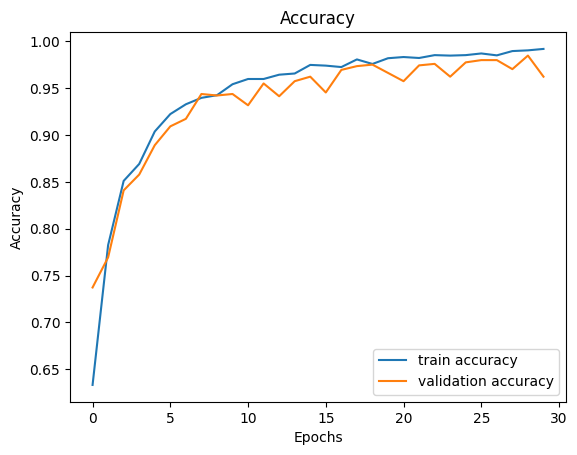

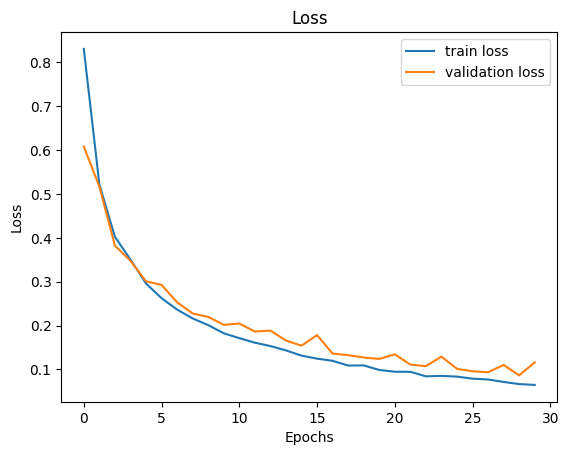

In [19]:
#Visualize Model Performance
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Evaluate the Model
test_loss, test_accuracy = final_model.evaluate(test_batches, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

39/39 [==============================] - 446s 12s/step - loss: 0.1129 - accuracy: 0.9655
Test Accuracy: 0.9655
Test Loss: 0.1129


39/39 [==============================] - 11s 197ms/step
Confusion Matrix
[[365   3   0]
 [ 26 406   0]
 [ 14   0 434]]
Classification Report
              precision    recall  f1-score   support

    Immature       0.90      0.99      0.94       368
      Mature       0.99      0.94      0.97       432
      Normal       1.00      0.97      0.98       448

    accuracy                           0.97      1248
   macro avg       0.96      0.97      0.96      1248
weighted avg       0.97      0.97      0.97      1248



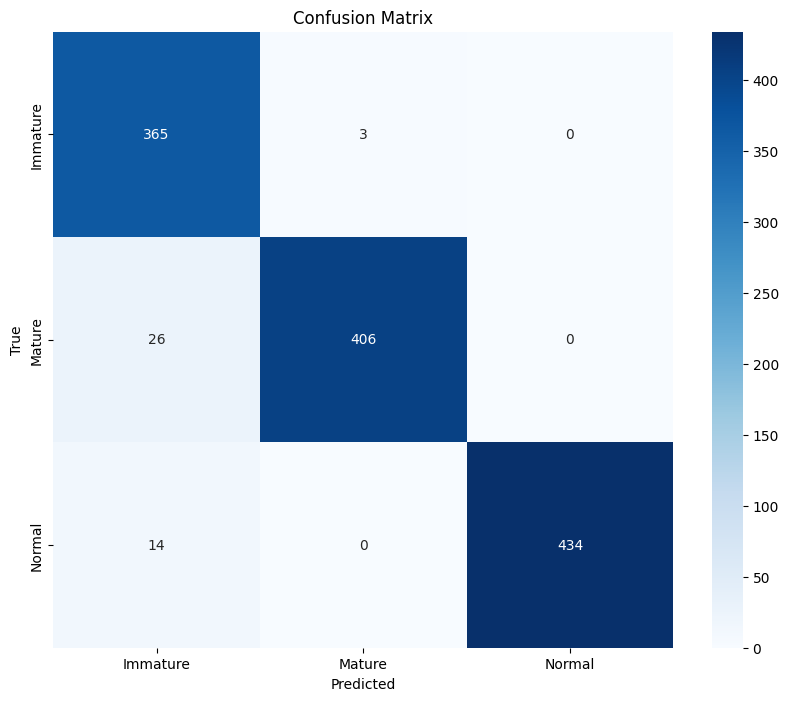

In [21]:
# Predict on Test Data
# Get the class labels
class_labels = list(test_batches.class_indices.keys())

# Reset the test_batches generator
test_batches.reset()

# Predict on the test data
predictions = final_model.predict(test_batches, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_batches.classes

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix')
print(conf_matrix)

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

FileUpload(value={}, accept='image/*', description='Upload')

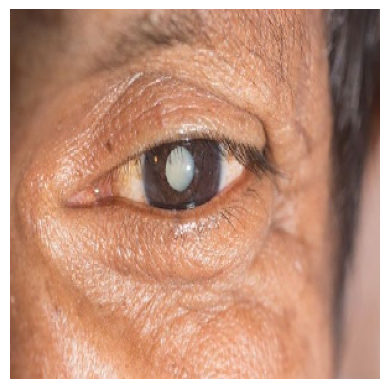

1/1 [==============================] - 0s 41ms/step
Predicted Label for test cataract.jpg: Mature


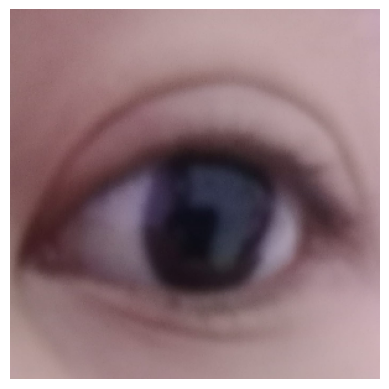

1/1 [==============================] - 0s 40ms/step
Predicted Label for WhatsApp Image 2024-05-31 at 22.22.18_30ebdf97.jpg: Normal


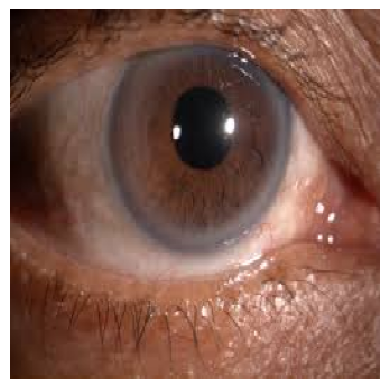

1/1 [==============================] - 0s 40ms/step
Predicted Label for images.jpeg: Immature


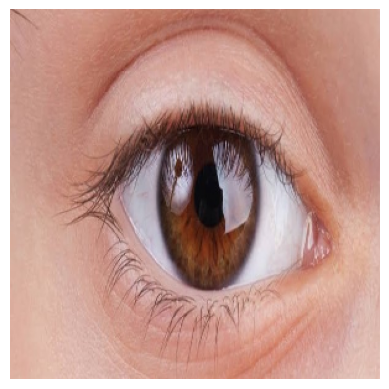

1/1 [==============================] - 0s 41ms/step
Predicted Label for news24_coid_1594833706.jpeg: Normal


In [38]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_resnet_v2.preprocess_input(img_array)
    return img_array

def predict_image(image_path):
    img_array = load_and_preprocess_image(image_path)
    single_prediction = final_model.predict(img_array)
    predicted_class = np.argmax(single_prediction, axis=1)
    predicted_label = class_labels[predicted_class[0]]
    return predicted_label

# File upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_file_upload_change(change):
    for filename, file_info in upload_widget.value.items():
        with open(filename, 'wb') as f:
            f.write(file_info['content'])
        # Display the uploaded image
        img = image.load_img(filename, target_size=(299, 299))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        # Make a prediction
        predicted_label = predict_image(filename)
        print(f"Predicted Label for {filename}: {predicted_label}")

upload_widget.observe(on_file_upload_change, names='value')
display(upload_widget)

In [41]:
import os

MODEL_BASE_PATH = "/content/drive/MyDrive/Bangkit 2024"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "inceptionresnetv.2.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

inception = InceptionResNetV2(weights='imagenet')

print('Saving Model At {}...'.format(save_model_path))
inception.save(save_model_path,include_optimizer=False)

225209952/225209952 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saving Model At /content/drive/MyDrive/Bangkit 2024/H5/inceptionresnetv.2.h5...
